# Implementation 2: ARIMA Model

Nvidia closing price prediction for T+10 trading days using Time series analysis

#### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import mean_squared_error

#### Import Nvidia Prices

Time period for data collection will be the past 1 year, to capture the current bearish trend.

In [4]:
nvda = yf.Ticker('NVDA')
start_date = '2021-10-23'
nvda_df = nvda.history(start = start_date)

# calculating returns for nvidia
nvda_returns = nvda_df.Close.pct_change().dropna()

Visualising Nvidia Closing Price data

Text(0, 0.5, 'Prices')

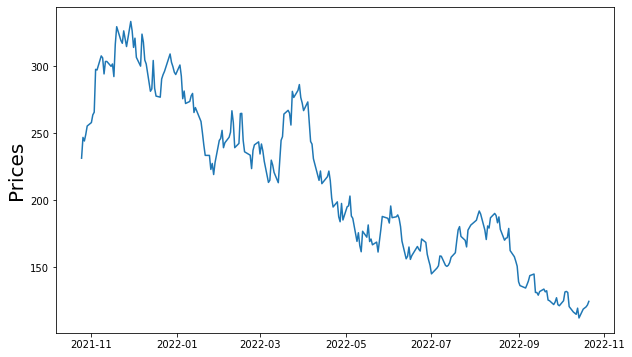

In [5]:
plt.figure(figsize=(10,6))
plt.plot(nvda_df.Close)
plt.ylabel('Prices', fontsize=20)

As can be seen, Nvidia price has been on a decreasing trend since the beginning of the year. The trend of the data isn't stationary.

#### Calculating Nvidia Returns


Trying to transform Nvidia Price data to daily returns, to see if the data will be stationary. The Augmented Dickey Fuller test will be conducted to test for stationarity.

Text(0, 0.5, 'Returns')

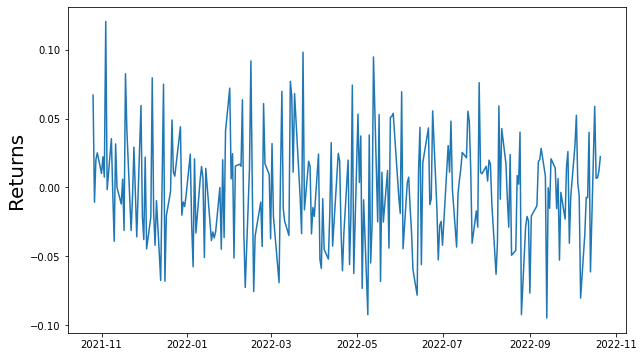

In [6]:
plt.figure(figsize=(10,6))
plt.plot(nvda_returns)
plt.ylabel('Returns', fontsize=20)

In [7]:
# define Augmented Dickey Fuller function
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [8]:
adf_test(nvda_returns)

ADF Statistic: -16.382140
p-value: 0.000000


P-value < 0.05, Nvidia daily returns is stationary according to Augmented Dickey Fuller test.

#### Splitting of training and testing data

In [9]:
train_test_split = 0.9
split_index = int(len(nvda_df.Close)*train_test_split)
train_data = nvda_df.Close[:split_index]
test_data = nvda_df.Close[split_index:]
train_data.shape, test_data.shape, nvda_df.Close.shape

((225,), (26,), (251,))

use of auto_arima is attempted to see if an optimal ARIMA model can be easily obtained.

In [10]:
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train_data, start_p = 1, start_q = 1,
                        test = 'adf',
                        max_p = 14, max_q = 14,
                        m = 1,
                        d = None,
                        seasonal = False,
                        start_P = 0,
                        D = 0,
                        trace = True,
                        error_action = 'ignore',
                        suppres_warnings = True,
                        stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1648.811, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3086.636, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1650.609, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1650.288, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2538.542, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1650.762, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1647.199, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2182.585, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1645.662, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2444.369, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1647.243, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1648.8

The results yield are inconclusive, results suggested using an AR(1) model which would be too simple. Next, ACF and PACF plots will be visualised.

#### ACF and PACF plots

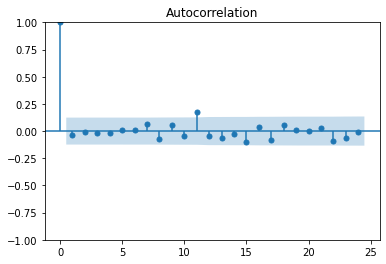

In [11]:
plot_acf(nvda_returns)
plt.show()

For the ACF plot, we can observe that the 11th lag is above the confidence interval.

c:\Users\raych\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


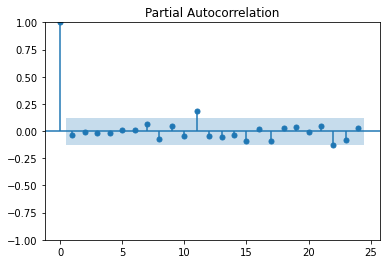

In [12]:
plot_pacf(nvda_returns)
plt.show()

For PACF plot, we also observe the significance of the 11th lag as compared to the rest. 

#### Creating ARIMA Model

Considering the results obtained from the ACF and PACF plots, a ARIMA(11,1,11) model will be used.

In [13]:
arma_model = ARIMA(train_data, order=(11,1,11))
arma_model_fit = arma_model.fit()
arma_model_fit.summary()

c:\Users\raych\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\raych\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\raych\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\raych\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  225
Model:               ARIMA(11, 1, 11)   Log Likelihood                -799.521
Date:                Sun, 23 Oct 2022   AIC                           1645.041
Time:                        04:29:43   BIC                           1723.509
Sample:                             0   HQIC                          1676.715
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0847      0.299     -0.283      0.777      -0.670       0.501
ar.L2         -0.2961      0.264     -1.120      0.263      -0.814       0.222
ar.L3          0.0634      0.307      0.206      0.837      -0.539       0.665
ar.L4         -0.6011      0.241     -2.491      0.013      -1.074      -0.128
ar.L5         -0.2197      0.367     -0.599      0.549      -0.939       0.499
ar.L6         -0.2500      0.357     -0.700      0.484      -0.950       0.450
ar.L7          0.0719      0.362      0.199      0.843      -0.638       0.782
ar.L8         -0.2717      0.224     -1.214      0.225      -0.710       0.167
ar.L9          0.0721      0.233      0.310      0.757      -0.384       0.528
ar.L10         0.1401      0.242      0.578      0.563      -0.335       0.615
ar.L11        -0.0814      0.243     -0.334      0.738      -0.559       0.396
ma.L1          0.0043      0.290      0.015      0.988      -0.564       0.573
ma.L2          0.2311      0.256      0.901      0.367      -0.271       0.734
ma.L3          0.0268      0.277      0.097      0.923      -0.515       0.569
ma.L4          0.6783      0.252      2.691      0.007       0.184       1.172
ma.L5          0.2550      0.345      0.739      0.460      -0.422       0.932
ma.L6          0.3092      0.364      0.849      0.396      -0.405       1.023
ma.L7         -0.0520      0.355     -0.146      0.884      -0.749       0.645
ma.L8          0.2311      0.246      0.938      0.348      -0.252       0.714
ma.L9         -0.0112      0.241     -0.047      0.963      -0.484       0.462
ma.L10        -0.1388      0.268     -0.518      0.604      -0.664       0.386
ma.L11         0.4225      0.276      1.532      0.125      -0.118       0.963
sigma2        72.6519     12.710      5.716      0.000      47.741      97.563
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.06
Prob(Q):                              0.94   Prob(JB):                         0.08
Heteroskedasticity (H):               0.39   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Unfortunately, p-values for the coefficients are mostly not sigificant. Nonetheless, we will just proceed with this anyway.

#### Plotting Visualisations

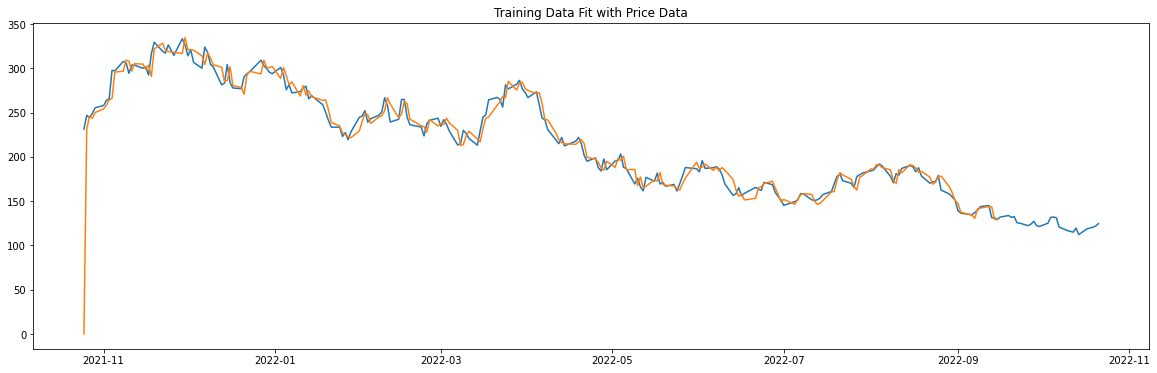

In [14]:
plt.figure(figsize=(20,6))
plt.title('Training Data Fit with Price Data')
plt.plot(nvda_df.Close)
plt.plot(arma_model_fit.fittedvalues)

#### Getting price predictions from ARIMA model

In [15]:
predictions = arma_model_fit.forecast(len(test_data))
predictions.index = test_data.index
residuals = test_data - predictions

c:\Users\raych\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 8.00280209079321


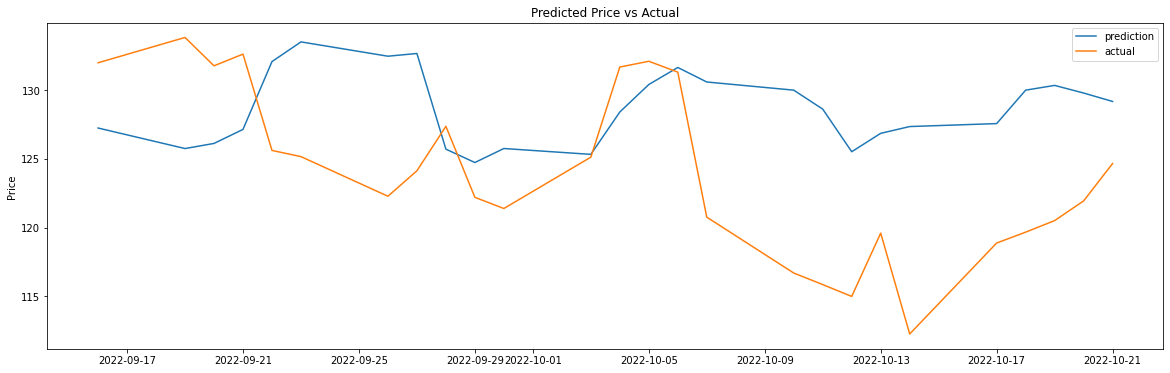

In [16]:

plt.figure(figsize=(20,6))
plt.plot(predictions, label = 'prediction')
plt.plot(test_data, label = 'actual')
plt.title('Predicted Price vs Actual')
plt.ylabel('Price')
plt.legend()
rmse = mean_squared_error(predictions, test_data, squared=False)
print("RMSE:", rmse)

Text(0.5, 1.0, 'Residuals')

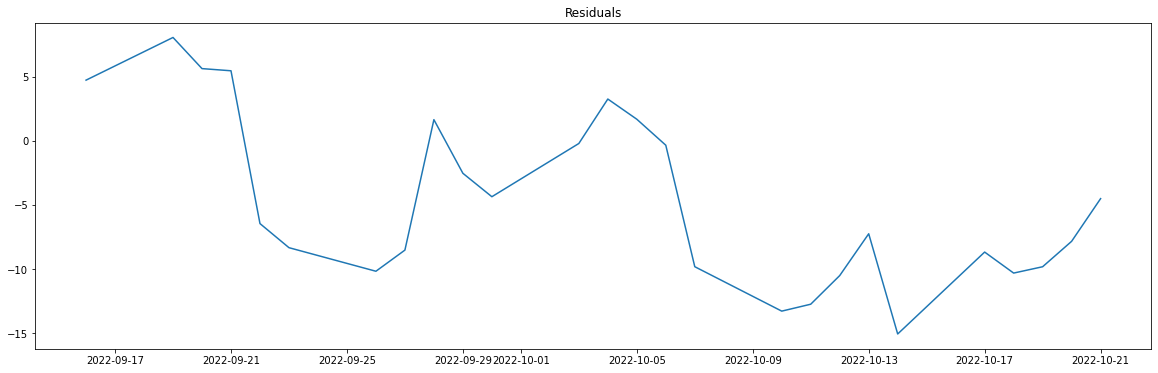

In [17]:
plt.figure(figsize=(20,6))
plt.plot(residuals)
plt.title('Residuals')

#### Getting T+10 Predictions

Retrain ARIMA(11,1,11) model with entire dataset.

In [18]:
arma_model = ARIMA(nvda_df.Close, order=(11,1,11))
arma_model_fit = arma_model.fit()
pred = arma_model_fit.forecast(10)

c:\Users\raych\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\raych\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\raych\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\raych\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization

<AxesSubplot:>

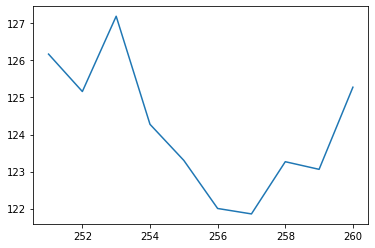

In [25]:
pred.plot()

In [24]:
pred.reset_index(drop=True).to_csv('ChngJinYangRay_Impl_2.csv')

#### Further Work

Nvidia stock forecasting was done using a univariate time series, without the usage of external variables to the model (due to time constraints). Perhaps using a ARIMAX model could yield better results.